# Topog form stress using MOM025 DATA

Recent update 09 Oct 2017

In [53]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import pickle
from numpy import math

import pandas as pd
import xarray as xr
from glob import glob
from mpl_toolkits.basemap import Basemap, shiftgrid


# Load Data

In [ ]:
g = 9.8

OceanFile1 = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7/output085/ocean/ocean_grid.nc'
dsx1 = xr.open_dataset(OceanFile1, engine='netcdf4')

OceanFile2 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7/output085/ocean/ocean_month.nc'
dsx2 = xr.open_dataset(OceanFile2, engine='netcdf4')

OceanFile3 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7/output085/ocean/ocean.nc'
dsx3 = xr.open_dataset(OceanFile3, engine='netcdf4')

pf=np.zeros([50,1080,1440])# store pbot*dz in each z-cell
mark=np.zeros([50,1080,1440]) 

for yy in range(100,400):
    kmt = dsx1.kmt.isel(yt_ocean=yy)    # "number of depth levels on t-grid"
    depth = dsx1.ht.isel(yt_ocean=yy)   # ht, depth
    pbot = 10000*dsx2.pbot_t.mean('time').isel(yt_ocean=yy)   # p_bot
    dz = dsx3.dzt.mean('time').isel(yt_ocean=yy)        # t-cell thickness
    rho = dsx3.rho.mean('time').isel(yt_ocean=yy)       # \rho in-situ    
    z=np.zeros(kmt.shape).astype(np.int64)              # define z initial
    z[:]=kmt[:].values-1                # layer number z[x]             
    for x in range(0,1440):
        if (z[x]>-1)&(z[x-1]>-1):      # x & x-1 are not continent landmasses  
            if z[x]-z[x-1]==0:
                dz1=depth[x-1]-depth[x]
                if dz1<0:
                    rhom=rho[z[x],x]
                    pf[z[x],yy,x]=pbot[x]*(-dz1)-g*rhom*(dz1)**2/2
                elif (dz1)>0:
                    rhom=rho[z[x-1],x-1]
                    pf[z[x],yy,x]=-1*(pbot[x-1]*(dz1)-g*rhom*(dz1)**2/2)
            else:
                if depth[x]-depth[x-1]>0:
                    dz1=depth[x]-depth[x-1]   # total depth difference
                    pa=10000*pbot[x]          # choose pbot pressure
                    zm=dz[z[x],x]             # dz of lowest layer
                    rhom=rho[z[x],x]          # density
                    pm = pa-zm*g*rhom/2       #pressure at middle of each partial cell
                    pf[z[x],yy,x-1]=pf[z[x],yy,x-1]+pm*zm
                    pa=pa-zm*g*rhom           #update press reference to upper partial cell
                    dz1=dz1-zm                    
                    for i in range(1,z[x]-z[x-1]):  #calculate from bottom partial cell in each layer             
                        zm=dz[z[x]-i,x]        
                        rhom=rho[z[x]-i,x]          #density
                        pm = pa-zm*g*rhom/2         #pressure at middle of each partial cell
                        pf[z[x]-i,yy,x-1]=pf[z[x]-i,yy,x-1]+pm*zm
                        mark[z[x]-i,yy,x-1]=1-mark[z[x]-i,yy,x-1]
                        pa=pa-zm*g*rhom             #update press reference to upper partial cell
                        dz1=dz1-zm
                    zm=dz1 # The top cell
                    rhom=rho[z[x-1],x]                
                    pm = pa-zm*g*rhom/2
                    pf[z[x-1],yy,x-1]=pf[z[x-1],yy,x-1]+pm*zm 
                    mark[z[x-1],yy,x-1]=1-mark[z[x-1],yy,x-1]
                elif depth[x]-depth[x-1]<0:
                    dz1=depth[x-1]-depth[x]
                    pa=10000*pbot[x-1]
                    zm=dz[z[x-1],x-1]
                    rhom=rho[z[x-1],x-1]
                    pm = pa-zm*g*rhom/2
                    pf[z[x-1],yy,x]=pf[z[x-1],yy,x]-pm*zm
                    pa=pa-zm*g*rhom 
                    dz1=dz1-zm
                    for i in range(1,z[x-1]-z[x]):
                        zm=dz[z[x-1]-i,x-1]
                        rhom=rho[z[x-1]-i,x-1]
                        pm = pa-zm*g*rhom/2
                        pf[z[x-1]-i,yy,x]=pf[z[x-1]-i,yy,x]-pm*zm
                        mark[z[x-1]-i,yy,x]=mark[z[x-1]-i,yy,x]-1
                        pa=pa-zm*g*rhom 
                        dz1=dz1-zm
                    zm=dz1
                    rhom=rho[z[x],x-1]                
                    pm = pa-zm*g*rhom/2
                    pf[z[x],yy,x]=pf[z[x],yy,x]-pm*zm
                    mark[z[x],yy,x]=mark[z[x],yy,x]-1
        elif (z[x]==0)&(z[x-1]<-1):      # only x-1 is continent landmass
            pa=10000*pbot[x]
            for i in range(0,z[x]+1):
                zm=dz[z[x]-i,x]
                rhom=rho[z[x]-i,x]
                pm = pa-zm*g*rhom/2
                pf[z[x]-i,yy,x-1]=pf[z[x]-i,yy,x-1]+pm*zm
                pa=pa-zm*g*rho
        elif (z[x]>0)&(z[x-1]<-1):      # only x-1 is continent landmass
            pa=10000*pbot[x]
            zm=dz[z[x],x]
            rhom=rho[z[x],x]
            pm = pa-zm*g*rhom/2
            pf[z[x],yy,x-1]=pf[z[x],yy,x-1]+pm*zm
            pa=pa-zm*g*rhom
            for i in range(1,z[x]+1):
                zm=dz[z[x]-i,x]
                rhom=rho[z[x]-i,x]
                pm = pa-zm*g*rhom/2
                pf[z[x]-i,yy,x-1]=pf[z[x]-i,yy,x-1]+pm*zm
                mark[z[x]-i,yy,x-1]=1-mark[z[x]-i,yy,x-1]
                pa=pa-zm*g*rhom
        elif (z[x]<-1)&(z[x-1]==0):     # only x is continent landmass
            pa=10000*pbot[x-1]
            for i in range(0,z[x-1]+1):
                zm=dz[z[x-1]-i,x-1]
                rhom=rho[z[x-1]-i,x-1]
                pm = pa-zm*g*rhom/2
                pf[z[x-1]-i,yy,x]=pf[z[x-1]-i,yy,x]-pm*zm
                pa=pa-zm*g*rhom                                   
        elif (z[x]<-1)&(z[x-1]>0):     # only x is continent landmass
            pa=10000*pbot[x-1]
            zm=dz[z[x-1],x-1]
            rhom=rho[z[x-1],x-1]
            pm = pa-zm*g*rhom/2
            pf[z[x-1],yy,x]=pf[z[x-1],yy,x]-pm*zm
            pa=pa-zm*g*rhom
            for i in range(1,z[x-1]+1):
                zm=dz[z[x-1]-i,x-1]
                rhom=rho[z[x-1]-i,x-1]
                pm = pa-zm*g*rhom/2
                pf[z[x-1]-i,yy,x]=pf[z[x-1]-i,yy,x]-pm*zm
                mark[z[x-1]-i,yy,x]=mark[z[x-1]-i,yy,x]-1
                pa=pa-zm*g*rhom

In [63]:
g = 9.8

OceanFile1 = '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7/output140/ocean/ocean_grid.nc'
dsx1 = xr.open_dataset(OceanFile1, engine='netcdf4')
dxu = dsx1.dxu ## dxu

OceanFile2 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7/output140/ocean/ocean_month.nc'
dsx2 = xr.open_dataset(OceanFile2, engine='netcdf4')
taux = dxu*dsx2.tau_x.mean('time')  ## tau_x
bmf = dxu*dsx2.bmf_u.mean('time') ##bmf_u

OceanFile2 =  '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7/output140/ocean/ocean_month.nc'



## Check and plot topographic form stress as a function of latitude

In [3]:
ts=np.sum(pf[:,100:360,:],axis=0)

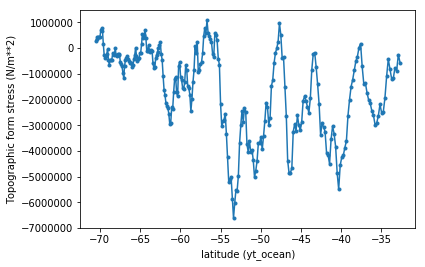

In [4]:
## output085
lat = dsx1.yt_ocean[100:360]
plt.plot(lat,np.sum(ts,axis=1),'.-')
plt.xlabel('latitude (yt_ocean)')
plt.ylabel('Topographic form stress (N/m**2)')

print np.sum(pf[:,100:360,:])

<xarray.DataArray ()>
array(-33127.93673081379)


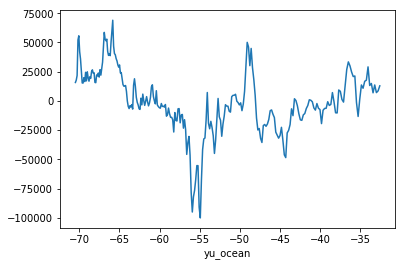

In [55]:
## output 085
dxu = dsx1.dxu ## dxu
bmf = dxu*dsx2.bmf_u.mean('time') ##bmf_u
ans = -bmf.sum('xu_ocean')
ans[100:360].plot()

print np.sum(ans[100:360])

<xarray.DataArray ()>
array(442052275.74498934)


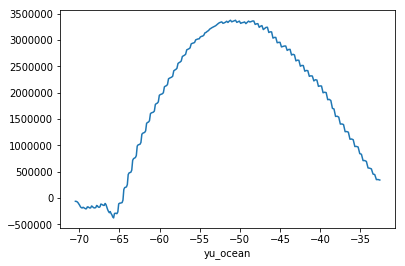

In [56]:
## output 085
dxu = dsx1.dxu ## dxu
taux = dxu*dsx2.tau_x.mean('time')  ## tau_x
ans = taux.sum('xu_ocean')
ans[100:360].plot()

print np.sum(ans[100:360])

<xarray.DataArray ()>
array(-648435.4540673575)


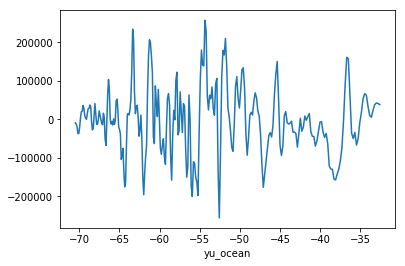

In [57]:
# output 085 momentum
u =dsx3.u.mean('time')
v=dsx3.v.mean('time')
dzt=dsx3.dzt.mean('time')
dxu = dsx1.dxu ## dxu
dyu = dsx1.dyu ## dyu

dz_arr=np.zeros(dzt.shape)
dz_arr[:] = dzt[:].values

uvdz = u*v*dz_arr
int_uv_dz=uvdz.sum('st_ocean')
int_uv_dz_new = np.zeros(int_uv_dz.shape)
int_uv_dz_new = int_uv_dz.values
int_uv_dz_new[np.isnan(int_uv_dz_new)]=0

uvdz_dy = np.zeros(int_uv_dz.shape)
uvdz_dy[1:-1] = (int_uv_dz_new[2:]-int_uv_dz_new[:-2])/2
uvdz_dy[0] = (int_uv_dz_new[1]-int_uv_dz_new[-1])/2
uvdz_dy[-1] = (int_uv_dz_new[0]-int_uv_dz_new[-2])/2

kernal = -1035*dxu*uvdz_dy/dyu

kernal[100:360].sum('xu_ocean').plot()

print np.sum(kernal[100:360])

### Comment: output 085
### form stress: -4.06*10^8
### wind stress: 4.4*10^8
### friction: -3.3*10^4
### momentum:  -6.5*10^5

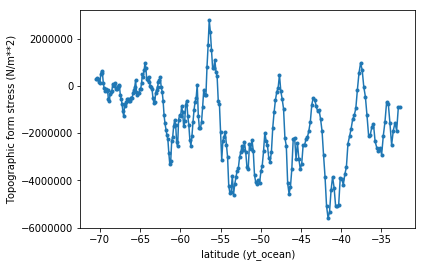

In [4]:
# output 140
lat = dsx1.yt_ocean[100:360]
plt.plot(lat,np.sum(ts,axis=1),'.-')
plt.xlabel('latitude (yt_ocean)')
plt.ylabel('Topographic form stress (N/m**2)')

print np.sum(pf[:,100:360,:])

<xarray.DataArray ()>
array(65604.13429709642)


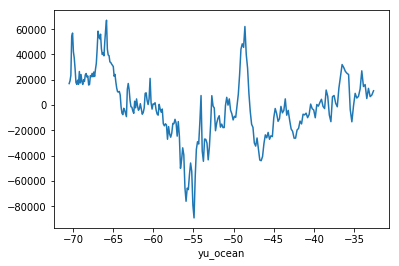

In [66]:
## output 140
dxu = dsx1.dxu ## dxu
bmf = dxu*dsx2.bmf_u.mean('time') ##bmf_u
ans = -bmf.sum('xu_ocean')
ans[100:360].plot()

print np.sum(ans[100:360])

<xarray.DataArray ()>
array(442176935.31295466)


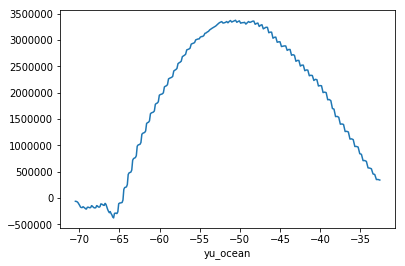

In [67]:
## output 140
dxu = dsx1.dxu ## dxu
taux = dxu*dsx2.tau_x.mean('time')  ## tau_x
ans = taux.sum('xu_ocean')
ans[100:360].plot()

print np.sum(ans[100:360])

<xarray.DataArray ()>
array(-648435.4540673575)


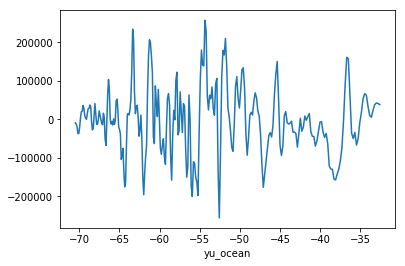

In [68]:
# output 140 momentum
u =dsx3.u.mean('time')
v=dsx3.v.mean('time')
dzt=dsx3.dzt.mean('time')
dxu = dsx1.dxu ## dxu
dyu = dsx1.dyu ## dyu

dz_arr=np.zeros(dzt.shape)
dz_arr[:] = dzt[:].values

uvdz = u*v*dz_arr
int_uv_dz=uvdz.sum('st_ocean')
int_uv_dz_new = np.zeros(int_uv_dz.shape)
int_uv_dz_new = int_uv_dz.values
int_uv_dz_new[np.isnan(int_uv_dz_new)]=0

uvdz_dy = np.zeros(int_uv_dz.shape)
uvdz_dy[1:-1] = (int_uv_dz_new[2:]-int_uv_dz_new[:-2])/2
uvdz_dy[0] = (int_uv_dz_new[1]-int_uv_dz_new[-1])/2
uvdz_dy[-1] = (int_uv_dz_new[0]-int_uv_dz_new[-2])/2

kernal = -1035*dxu*uvdz_dy/dyu

kernal[100:360].sum('xu_ocean').plot()

print np.sum(kernal[100:360])

### Comment: output 140
### form stress: wait for cal
### wind stress: 4.4*10^8
### friction: 6.6*10^4
### momentum: 6.5*10^5

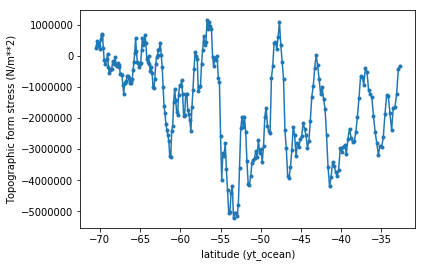

In [444]:
# output100 

lat = dsx1.yt_ocean[100:360]
plt.plot(lat,np.sum(ts,axis=1),'.-')
plt.xlabel('latitude (yt_ocean)')
plt.ylabel('Topographic form stress (N/m**2)')

print np.sum(pf[:,100:360,:])

<xarray.DataArray ()>
array(972.4042508659195)


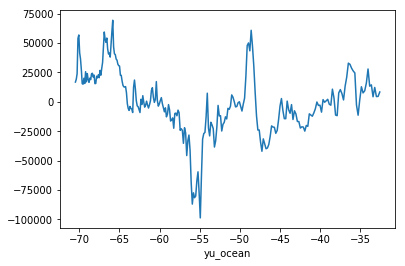

In [60]:
## output 100
dxu = dsx1.dxu ## dxu
bmf = dxu*dsx2.bmf_u.mean('time') ##bmf_u
ans = -bmf.sum('xu_ocean')
ans[100:360].plot()

print np.sum(ans[100:360])

<xarray.DataArray ()>
array(442087941.83067906)


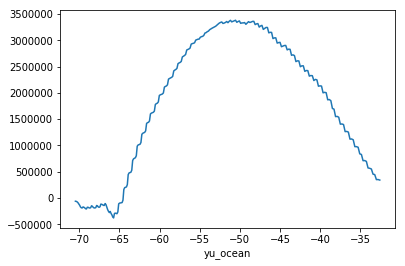

In [61]:
## output 100
dxu = dsx1.dxu ## dxu
taux = dxu*dsx2.tau_x.mean('time')  ## tau_x
ans = taux.sum('xu_ocean')
ans[100:360].plot()

print np.sum(ans[100:360])

<xarray.DataArray ()>
array(-648435.4540673575)


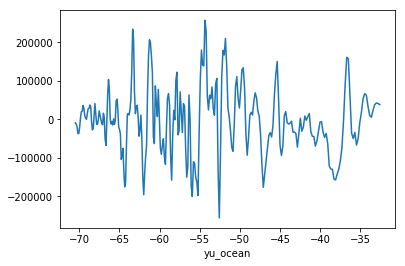

In [62]:
# output 100 momentum
u =dsx3.u.mean('time') # u velocity
v=dsx3.v.mean('time')  # v velocity
dzt=dsx3.dzt.mean('time') # dzt grid 
dxu = dsx1.dxu ## dxu
dyu = dsx1.dyu ## dyu

dz_arr=np.zeros(dzt.shape) # define dz grid 
dz_arr[:] = dzt[:].values  # define a numpy array with same value of dzt 
                            # reason dzt (xt_ocean,yt_ocean) while u(xu_ocean,yu_ocean) different parameters

uvdz = u*v*dz_arr # u*v*dz
int_uv_dz=uvdz.sum('st_ocean') # int (u*v*dz) along z axis
int_uv_dz_new = np.zeros(int_uv_dz.shape) # define this value to set 'NAN' as 0
int_uv_dz_new = int_uv_dz.values
int_uv_dz_new[np.isnan(int_uv_dz_new)]=0

uvdz_dy = np.zeros(int_uv_dz.shape)
uvdz_dy[1:-1] = (int_uv_dz_new[2:]-int_uv_dz_new[:-2])/2 # d(\int u*v*dz)n=0.5*(\int u*v*dz_n+1-\int u*v*Dz_n-1)
uvdz_dy[0] = (int_uv_dz_new[1]-int_uv_dz_new[-1])/2
uvdz_dy[-1] = (int_uv_dz_new[0]-int_uv_dz_new[-2])/2

kernal = -1035*dxu*uvdz_dy/dyu  # rho_0* d(\int u*v*dz)/dy *dx

kernal[100:360].sum('xu_ocean').plot()  # \int [rho_0* d(\int u*v*dz)/dy *dx]

print np.sum(kernal[100:360])

### Comment: output 100
### form stress: -3.78*10^8
### wind stress: 4.4*10^8
### friction:  9*10^2
### momentum: -6.5*10^5